In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [2]:
train_df = pd.read_parquet("data/train_data.pqt")
test_df = pd.read_parquet("data/test_data.pqt")

<Axes: xlabel='end_cluster'>

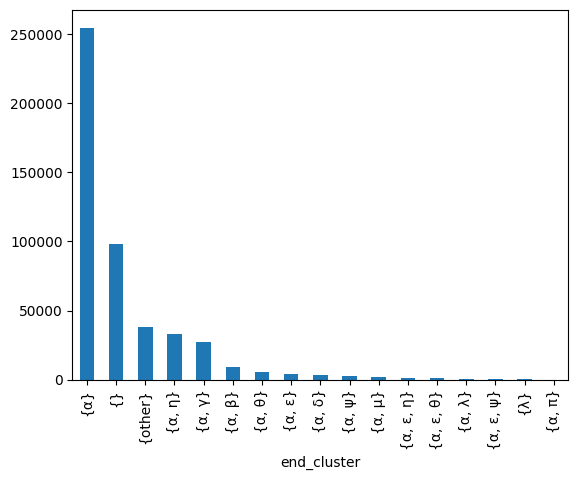

In [98]:
y_train.value_counts().plot(kind='bar')

#### target class - "end_cluster" (df[-1])

In [6]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "start_cluster",
    "index_city_code", "ogrn_month", "ogrn_year",
]

cat_cols_num = []

In [7]:
for x,y in zip(test_df.columns, test_df.isna().sum()):
    print(x, "---", y)

id --- 0
date --- 0
balance_amt_avg --- 29483
balance_amt_max --- 29483
balance_amt_min --- 29483
balance_amt_day_avg --- 29483
channel_code --- 20028
city --- 60612
city_type --- 60992
index_city_code --- 156461
ogrn_days_end_month --- 14278
ogrn_days_end_quarter --- 14278
ogrn_month --- 14278
ogrn_year --- 14278
ft_registration_date --- 14838
max_founderpres --- 161192
min_founderpres --- 161192
ogrn_exist_months --- 14278
okved --- 14479
segment --- 14020
sum_of_paym_2m --- 73461
sum_of_paym_6m --- 73461
sum_of_paym_1y --- 73461
sum_a_oper_1m --- 0
cnt_a_oper_1m --- 95210
sum_b_oper_1m --- 0
cnt_b_oper_1m --- 95210
sum_c_oper_1m --- 0
cnt_c_oper_1m --- 95210
sum_deb_d_oper_1m --- 0
cnt_deb_d_oper_1m --- 95210
sum_cred_d_oper_1m --- 0
cnt_cred_d_oper_1m --- 95210
sum_deb_e_oper_1m --- 0
cnt_deb_e_oper_1m --- 95210
cnt_days_deb_e_oper_1m --- 95210
sum_cred_e_oper_1m --- 0
cnt_cred_e_oper_1m --- 95210
cnt_days_cred_e_oper_1m --- 95210
sum_deb_f_oper_1m --- 0
cnt_deb_f_oper_1m --- 95210

Создаем выборки для валидации и обучения

In [48]:
to_drop_cols = [
    "date",
    'cnt_a_oper_1m', "cnt_b_oper_1m", 'cnt_c_oper_1m', 'cnt_deb_d_oper_1m','cnt_cred_d_oper_1m','cnt_deb_e_oper_1m','cnt_days_deb_e_oper_1m','cnt_cred_e_oper_1m','cnt_days_cred_e_oper_1m',
    'cnt_deb_f_oper_1m','cnt_days_deb_f_oper_1m','cnt_cred_f_oper_1m','cnt_days_cred_f_oper_1m','cnt_deb_g_oper_1m',
    'cnt_days_deb_g_oper_1m','cnt_cred_g_oper_1m','cnt_days_cred_g_oper_1m','cnt_deb_h_oper_1m','cnt_days_deb_h_oper_1m','cnt_cred_h_oper_1m','cnt_days_cred_h_oper_1m',
    'cnt_days_cred_h_oper_3m','cnt_cred_h_oper_3m','cnt_days_deb_h_oper_3m','cnt_deb_h_oper_3m','cnt_days_cred_g_oper_3m','cnt_cred_g_oper_3m','cnt_days_deb_g_oper_3m','cnt_deb_g_oper_3m','cnt_days_cred_f_oper_3m','cnt_cred_f_oper_3m','cnt_days_deb_f_oper_3m','cnt_deb_f_oper_3m','cnt_days_cred_e_oper_3m','cnt_cred_e_oper_3m','cnt_days_deb_e_oper_3m','cnt_deb_e_oper_3m','cnt_cred_d_oper_3m','cnt_deb_d_oper_3m','cnt_c_oper_3m','cnt_b_oper_3m','cnt_a_oper_3m',

    'sum_of_paym_2m', 'sum_of_paym_6m', 'sum_of_paym_1y',

    'balance_amt_max','balance_amt_min','balance_amt_day_avg','index_city_code',

    'ogrn_days_end_month', 'ogrn_days_end_quarter','ogrn_month','ogrn_year','max_founderpres','min_founderpres','ogrn_exist_months'
]
to_drop_cols.append("id")

In [151]:
raw_X = train_df.drop(to_drop_cols, axis=1)

raw_X['balance_amt_avg'] = raw_X['balance_amt_avg'].fillna(raw_X['balance_amt_avg'].mean())
raw_X['channel_code'] = raw_X['channel_code'].fillna('channel_code_8')
raw_X['city']= raw_X['city'].fillna('city_0')
raw_X['city_type']= raw_X['city_type'].fillna('city_type_0')
raw_X['ft_registration_date'] = raw_X['ft_registration_date'].fillna(0.407456)
raw_X['okved']= raw_X['okved'].fillna('okved_5')
raw_X['segment']= raw_X['segment'].fillna('segment_3')

y = raw_X["end_cluster"]
raw_X = raw_X.drop(['end_cluster'],axis=1)

x_train, x_val, y_train, y_val = train_test_split(raw_X, y,
                                                  test_size=0.2,
                                                  random_state=42)


In [150]:
for i, col in enumerate(cat_cols):
    for j, col1 in enumerate(x_train.columns):
        if col == col1:
            cat_cols_num.append(j)
cat_cols_num = list(set(sorted(cat_cols_num)))
cat_cols_num

[1, 2, 3, 33, 5, 6]

In [191]:
model = CatBoostClassifier(iterations=10,
                           depth=8,
                           learning_rate=0.1,
                        #    loss_function='AUC',
                           custom_loss=['AUC', 'MultiClass'],
                           verbose=True,
                           random_state=1337)
# train the model
model.fit(x_train, y_train,
        cat_features=cat_cols_num,
        eval_set=(x_val, y_val),
        verbose=True,
)
# make the prediction using the resulting model
# preds_class = model.predict(x_val)
preds_proba = model.predict_proba(x_val)
# print("class = ", preds_class)
print("proba = ", preds_proba)

0:	learn: 2.0608403	test: 2.0560844	best: 2.0560844 (0)	total: 7.82s	remaining: 1m 10s
1:	learn: 1.8082862	test: 1.8044647	best: 1.8044647 (1)	total: 15.1s	remaining: 1m
2:	learn: 1.6437051	test: 1.6396733	best: 1.6396733 (2)	total: 22.7s	remaining: 53s
3:	learn: 1.5212214	test: 1.5177716	best: 1.5177716 (3)	total: 30.2s	remaining: 45.3s
4:	learn: 1.4255747	test: 1.4228625	best: 1.4228625 (4)	total: 37.5s	remaining: 37.5s
5:	learn: 1.3490643	test: 1.3468817	best: 1.3468817 (5)	total: 44.8s	remaining: 29.8s
6:	learn: 1.2869704	test: 1.2854725	best: 1.2854725 (6)	total: 52s	remaining: 22.3s
7:	learn: 1.2354968	test: 1.2343920	best: 1.2343920 (7)	total: 59.6s	remaining: 14.9s
8:	learn: 1.1919397	test: 1.1913817	best: 1.1913817 (8)	total: 1m 7s	remaining: 7.49s
9:	learn: 1.1538471	test: 1.1537432	best: 1.1537432 (9)	total: 1m 15s	remaining: 0us

bestTest = 1.153743193
bestIteration = 9

proba =  [[0.02449172 0.54051907 0.02029303 ... 0.01965308 0.15780968 0.01930744]
 [0.04223291 0.4103251

#### Eval

Зададим функцию для взвешенной метрики roc auc

In [192]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [155]:
cluster_weights = pd.read_excel("cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [193]:
y_pred_proba = model.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.8589139198433902

#### Sub

In [171]:
sample_submission_df = pd.read_csv("sample_submission.csv")

test_df["start_cluster"] = train_df["start_cluster"].mode()[0]

test_df['balance_amt_avg'] = test_df['balance_amt_avg'].fillna(test_df['balance_amt_avg'].mean())
test_df['channel_code'] = test_df['channel_code'].fillna('channel_code_8')
test_df['city']= test_df['city'].fillna('city_0')
test_df['city_type']= test_df['city_type'].fillna('city_type_0')
test_df['ft_registration_date'] = test_df['ft_registration_date'].fillna(0.407456)
test_df['okved']= test_df['okved'].fillna('okved_5')
test_df['segment']= test_df['segment'].fillna('segment_3')

last_m_test_df = test_df[test_df["date"] == "month_6"]
last_m_test_df = last_m_test_df.drop(to_drop_cols, axis=1)

In [186]:
test_pred_proba = model.predict_proba(last_m_test_df)
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = test_pred_proba_df.columns.to_list()
test_pred_proba_df = test_pred_proba_df[sorted_classes]

In [188]:
test_pred_proba_df['id'] = test_df['id']

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("sub.csv", index=False)